In [1]:
import bom_water
from sidecar import Sidecar
from ipyleaflet import Map, GeoJSON, Polygon
from IPython.display import display, clear_output, HTML, JSON
import shapely
import shapely.geometry
import json
import requests
import sys
from geojson import Feature, FeatureCollection, Point
import geopandas as gpd

## Setup some constants

In [2]:
bm = bom_water.BomWater()
procedure = bm.procedures.Pat4_C_B_1_DailyMean
prop = bm.properties.Water_Course_Discharge

#### Bounding Box for the MDB

In [3]:
low_left_lat = -37.505032
low_left_long = 138.00
upper_right_lat = -24.00
upper_right_long = 154.00

lower_left_coords = f'{low_left_lat} {low_left_long}'
upper_right_coords = f'{upper_right_lat} {upper_right_long}'

## Get Feature of interest for the MDB for:
- Property - Water Course Discharge
- Procedure - Pat4_C_B_1_DailyMean

Note - the BOM api is unable to filter base on a polygon, so a bounding box is used to obtain all point and then the Geofabric geometery is used to filter the results

In [37]:

# request( action, feature=None, prop=None, proced=None, begin=None, end=None, lower_corner=None, upper_corner=None)

response = bm.request(bm.actions.GetFeatureOfInterest, None, prop, procedure, None, None, lower_left_coords, upper_right_coords  )
response_json = bm.xml_to_json(response.text)
'''bomwater creates a FeatureCollection which can be used for mapping'''
feature_list = bm.create_feature_list(response_json, None )

bbox_poly = Polygon(
        locations=[(low_left_lat, low_left_long),(low_left_lat, upper_right_long),(upper_right_lat, upper_right_long),(upper_right_lat, low_left_long)],
    color="green",
    fill_color="green"
        )
m = Map(center=(-32, 146), zoom=5)

geojsonMarkerOptions = {
    'radius': 8,
    'fillColor': "#ff7800",
    'color': "#000",
    'weight': 1,
    'opacity': 1,
    'fillOpacity': 0.8
};

geo_json_stations = GeoJSON(
    data=feature_list,
    point_style={'radius': 5, 'color': 'blue', 'fillOpacity': 0.8, 'fillColor': 'green', 'weight': 2})


def random_color(feature):
    return {
        'color': 'black',
        'fillColor': 'green',#random.choice(['red', 'yellow', 'green', 'orange']),
    }

shp_mdb = './bomwater_data/Spatial/mdb_buffer_1km.shp'
mdb = json.loads(gpd.read_file(shp_mdb).to_json())['features'][0]['geometry']

geo_json_mdb = GeoJSON(
    data=mdb,
    style={
        'opacity': 1, 'dashArray': '9', 'fillOpacity': 0.1, 'weight': 1
    },
    hover_style={
        'color': 'green', 'dashArray': '0', 'fillOpacity': 0.3
    },
    style_callback=random_color
)

m.add_layer(geo_json_mdb)
m.add_layer(bbox_poly)
m.add_layer(geo_json_stations)

display(m)

'''Display the json response'''
# JSON(response_json)

Map(center=[-32, 146], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_t…

'Display the json response'

## Filter the above results (from using a bbox) using a Geofabric geometry of the MDB

In [32]:
def write_json_features(features, file):
    collection = FeatureCollection(features)
    with open(file, "w") as f:
        f.write('%s' % collection)

In [33]:
mdb_sites = []
shp_mdb = './bomwater_data/Spatial/mdb_buffer_1km.shp'
mdb = json.loads(gpd.read_file(shp_mdb).to_json())['features'][0]['geometry']
mdb_coords = mdb['coordinates']
poly_mdb = shapely.geometry.Polygon(mdb_coords[0])#mdb_coords is a multipolgon, so the 2nd index has the main poly of interest
display(poly_mdb)
for f in feature_list['features']:
    point = shapely.geometry.Point(f['geometry']['coordinates'])
    
    if point.within(poly_mdb):
#         print(f'Points X: {point.x}, Point Y: {point.y}')
        mdb_sites.append(f)
mdb_sites
write_json_features(mdb_sites, f'./bomwater_data/mdb_water_coarse_discharge/mdb_WaterCourseDischarge_stations.json')

In [34]:
'''Quick look at the results'''
display(mdb_sites[0])
print(f'Found - {len(mdb_sites)} sites within the MDB')

{"geometry": {"coordinates": [146.244072, -36.619458], "type": "Point"}, "properties": {"long_name": "http://bom.gov.au/waterdata/services/stations/403213", "name": "15_MILE_@_GRETA_STH", "stationId": null, "stationNo": "403213"}, "type": "Feature"}

Found - 1432 sites within the MDB


## Obtain one observations for display

Value[cumec]  Quality Interpolation
Timestamp[UTC]                                          
1958-12-14 14:00:00           NaN       -1     ConstSucc
1958-12-15 14:00:00         1.010       10     ConstSucc
1958-12-16 14:00:00         1.023       10     ConstSucc
1958-12-17 14:00:00         0.966       10     ConstSucc
1958-12-18 14:00:00         0.926       10     ConstSucc
...                           ...      ...           ...
2022-10-29 14:00:00        12.340       10     ConstSucc
2022-10-30 14:00:00        13.539       10     ConstSucc
2022-10-31 14:00:00        13.899       10     ConstSucc
2022-11-01 14:00:00        12.544       10     ConstSucc
2022-11-02 14:00:00           NaN       -1     ConstSucc

[23335 rows x 3 columns]

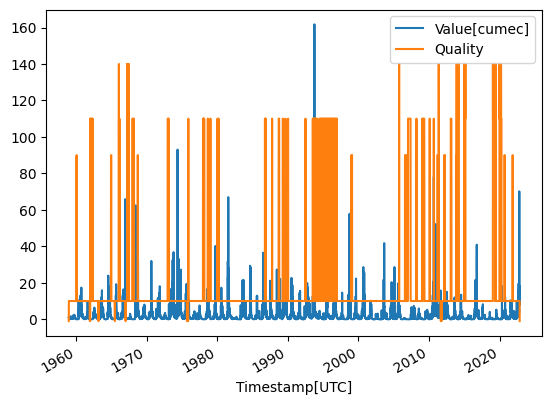

In [35]:
t_begin = "1800-01-01T00:00:00+10"
t_end = "2030-12-31T00:00:00+10"

try:
    response = bm.request(bm.actions.GetObservation, mdb_sites[0]['properties']['stationNo'], prop, procedure, t_begin, t_end)
except response.exceptions.RequestException as e:
    display(f'BoM service failed with RequestException: {e}')

response_json = bm.xml_to_json(response.text)  
ts = bm.parse_get_data(response)
ts.plot.line()
ts

In [36]:
import logging
import sys

logging.basicConfig(
    level=logging.INFO, 
    format='[{%(filename)s:%(lineno)d} %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler(filename='tmp5a.log'),
        logging.StreamHandler(sys.stdout)
    ]
)

logger = logging.getLogger('TS_Saver')

### Write all data to disk

In [ ]:
'''Note: Folders should exist before running'''
for sites in mdb_sites:
    try:
        response = bm.request(bm.actions.GetObservation, sites['properties']['stationNo'], prop, procedure, t_begin, t_end)
        ts = bm.parse_get_data(response)
        stationNo = sites['properties']['stationNo']
        if len(ts.index) < 1:
            logger.warning(f'Data length is zero for station: {stationNo}')
        else:
            ts.to_csv(f'./bomwater_data/mdb_water_coarse_discharge/{stationNo}.csv')
    except:
        e = sys.exc_info()[0]
        stationNo = sites['properties']['stationNo']
        logger.warning(f'BoM service failed with system info: {e} for station: {stationNo}')
        